# Herron Topic 5 - Simulations

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from scipy.stats import norm # new addition for Monte Carlo methods
import yfinance as yf

In [2]:
%precision 2
pd.options.display.float_format = '{:.2f}'.format
# %config InlineBackend.figure_format = 'retina'

In finance, we use two main simulation methods: Monte Carlo and bootstrap.
Both help analyze financial data, but work differently.

**Monte Carlo** methods create many possible paths of financial variables (e.g., stock prices, interest rates) based on theoretical probability distributions:

- Generates synthetic data from assumed models
- Creates data that may not exist in historical records
- Based on random sampling from probability distributions

**Bootstrap** methods take a different approach:

- Resamples from actual historical data (with or without replacement)
- Makes minimal assumptions about distributions
- Maintains statistical properties of original data

Check
    [Monte Carlo methods](https://en.wikipedia.org/wiki/Monte_Carlo_method),
    [Bootstrapping (statistics)](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)),
    and
    [Monte Carlo methods in finance](https://en.wikipedia.org/wiki/Monte_Carlo_methods_in_finance)
    for details.


In this lecture notebook, we focus on:
1. *Option pricing:* Monte Carlo methods can estimate derivative values by simulating future asset paths and calculating discounted expected payoffs.
2. *Value at Risk (VaR):* Both methods help compute this risk metric to estimate potential portfolio losses at specific confidence levels.

Specifically, we will simulate AAPL price paths and price a call option, then compute VaR for a portfolio of GOOG and META.

## Estimating Option Prices with Monte Carlo Methods

We can use Monte Carlo methods to value stock options.
First, we simulate several thousand random price paths for the underlying stock.
Then, we calculate the payoff for each path.
Along some paths, the option will expire "in the money" with $S_T > K$ and pay $S_T - K$.
Along other paths, the option will expire "out of the money" with $S_T < K$ and pay 0.
We average these payoffs and discount them to today.
The present value of this expected payoffs is the option price.
This is a simple example, and there is a lot of depth to [Monte Carlo methods for option pricing](https://en.wikipedia.org/wiki/Monte_Carlo_methods_for_option_pricing).

### Simulating Stock Prices

We can simulate stock prices with the following stochastic differential equation (SDE) for Geometric Brownian Motion (GBM):
$$
dS = \mu S dt + \sigma S dW_t.
$$
GBM does not account for mean-reversion and time-varying volatility.
So GBM is often used for stocks and not for bond prices, which tend to revert to face value in the long-term.
In the SDE for GBM:

1. $S$ is the stock price
1. $\mu$ is the drift coefficient (i.e., instantaneous expected return)
1. $\sigma$ is the diffusion coefficient (i.e., volatility of the drift)
1. $W_t$ is the Wiener Process or Brownian Motion

The GBM SDE has a closed-form solution:
$$
S(t) = S_0 \exp\left(\left(\mu - \frac{1}{2}\sigma^2\right)t + \sigma W_t\right).
$$
We can iteratively apply this closed form solution:
$$
S(t_{i+1}) = S(t_i) \exp\left(\left(\mu - \frac{1}{2}\sigma^2\right)(t_{i+1} - t_i) + \sigma \sqrt{t_{i+1} - t_i} Z_{i+1}\right).
$$
Here, $Z_i$ is a Standard Normal random variable (becuase $dW_t$ are independent and normally distributed) and $i = 0, \ldots, T-1$ is the time index.

We can use this closed form solution to simulate stock prices for AAPL.

In [3]:
aapl = (
    yf.download(
        tickers='AAPL',
        auto_adjust=False,
        progress=False,
        multi_level_index=False
    )
    .iloc[:-1]
    .assign(Return=lambda x: x['Adj Close'].pct_change())
)

We can use returns from 2021 to predict price paths in 2022 (i.e., *train* in 2021, and *test* in 2022).

In [5]:
train = aapl.loc['2021']
test = aapl.loc['2022']

We can use the following `simulate_gbm()` function to simulate one price path.
Throughout this lecture notebook, we will use one-trading-day steps (i.e., `dt=1`).

In [7]:
def simulate_gbm(S_0, mu, sigma, n_steps, dt=1, seed=42):
    '''
    Function to simulate stock prices following Geometric Brownian Motion (GBM).
    
    Parameters
    ------------
    S_0 : float
        Initial stock price
    mu : float
        Drift coefficient
    sigma : float
        Diffusion coefficient
    n_steps : int
        Length of the forecast horizon in time increments, so T = n_steps * dt
    dt : int
        Time increment, typically one day
    seed : int
        Random seed for reproducibility

    Returns
    -----------
    S_t : np.ndarray
        Array (length: n_steps + 1) of simulated prices
    '''

    np.random.seed(seed)
    dW = np.random.normal(scale=np.sqrt(dt), size=n_steps)
    W = dW.cumsum()
    
    t = np.linspace(dt, n_steps * dt, n_steps)
    
    S_t = S_0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * W)
    S_t = np.insert(S_t, 0, S_0)
    
    return S_t

Here is one simulated price path:

In [13]:
S_0 = train['Adj Close'].iloc[-1]
mu = train['Return'].pipe(np.log1p).mean()
sigma = train['Return'].pipe(np.log1p).std()
n_steps = test.shape[0]

simulate_gbm(S_0=S_0, mu=mu, sigma=sigma, n_steps=n_steps)

array([174.52, 176.08, 175.88, 177.88, 182.4 , 181.92, 181.44, 186.22,
       188.69, 187.5 , 189.31, 188.13, 186.95, 187.86, 182.46, 177.74,
       176.35, 173.73, 174.78, 172.47, 168.84, 172.98, 172.55, 172.92,
       169.24, 167.97, 168.44, 165.58, 166.74, 165.34, 164.76, 163.37,
       168.4 , 168.54, 165.92, 168.27, 165.23, 165.95, 161.06, 157.88,
       158.54, 160.57, 161.18, 161.05, 160.46, 156.92, 155.3 , 154.34,
       157.11, 158.13, 153.95, 154.9 , 154.12, 152.64, 154.29, 156.99,
       159.49, 157.55, 156.95, 157.94, 160.56, 159.52, 159.22, 156.62,
       153.85, 156.01, 159.56, 159.54, 162.26, 163.37, 161.88, 162.98,
       167.17, 167.25, 171.62, 164.83, 167.16, 167.57, 166.95, 167.37,
       162.37, 161.98, 163.07, 167.1 , 165.91, 163.97, 162.85, 165.4 ,
       166.44, 165.22, 166.74, 167.18, 169.94, 168.24, 167.54, 166.69,
       163.05, 163.98, 164.84, 165.02, 164.59, 161.11, 160.22, 159.52,
       157.68, 157.44, 158.62, 163.59, 164.21, 165.06, 165.04, 160.28,
      

We can combine `simulate_gbm()` with a list comprehension and `pd.concat()` to simulate and collect many price paths.

In [14]:
n = 100
S_t = pd.concat(
    objs=[
        pd.Series(
            data=simulate_gbm(S_0=S_0, mu=mu, sigma=sigma, n_steps=n_steps, seed=seed),
            index=test.index.insert(0, train.index[-1])
        )
        for seed in range(n)
    ],
    axis=1,
    keys=range(n),
    names=['Simulation']
)

In [17]:
S_t.iloc[:5, :5]

Simulation,0,1,2,3,4
Date,,,,,
2021-12-31,174.52,174.52,174.52,174.52,174.52
2022-01-03,179.64,179.24,173.55,179.71,174.84
2022-01-04,180.97,177.71,173.58,181.15,176.41
2022-01-05,183.99,176.42,168.00,181.61,173.84
2022-01-06,190.82,173.63,172.59,176.53,175.94


We can prefix the simulated price path column names with `_` to hide them from the legend.

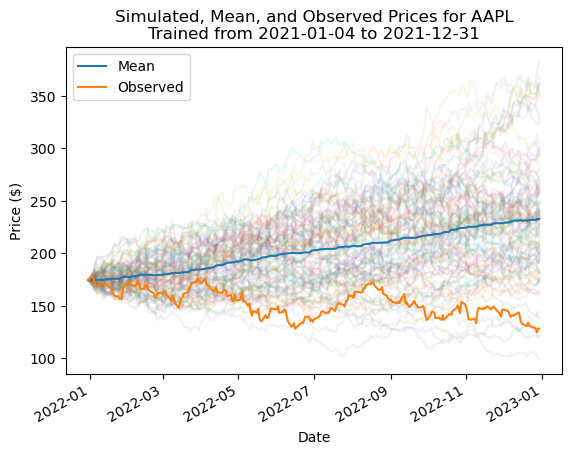

In [19]:
fig, ax = plt.subplots(1,1)
S_t.add_prefix('_').plot(alpha=0.1, ax=ax)
S_t.mean(axis=1).plot(label='Mean', ax=ax)
aapl.loc[S_t.index, 'Adj Close'].plot(label='Observed', ax=ax)
plt.legend()
plt.ylabel('Price ($)')
plt.title(
    'Simulated, Mean, and Observed Prices for AAPL' + 
    f'\nTrained from {train.index[0]:%Y-%m-%d} to {train.index[-1]:%Y-%m-%d}'
)
plt.show()

### Simulating Option Prices

We can use these simulated price paths to price options!
We can use the @black1973pricing formula as a benchmark.
@black1973pricing provide an analytic or closed form solution to price European options.

In [22]:
def price_bs(S_0, K, T, r, sigma, type='call'):
    '''
    Function used for calculating the price of European options using the analytical form of the Black-Scholes model.
    
    Parameters
    ------------
    S_0 : float
        Initial stock price
    K : float
        Strike price
    T : float
        Time to expiration in days
    r : float
        Daily risk-free rate
    sigma : float
        Standard deviation of daily stock returns
    type : str
        Type of the option. Allowable: ['call', 'put']
    
    Returns
    -----------
    option_premium : float
        The premium on the option calculated using the Black-Scholes model
    '''
    
    d1 = (np.log(S_0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if type == 'call':
        val = (norm.cdf(d1, 0, 1) * S_0) - (norm.cdf(d2, 0, 1) * K * np.exp(-r * T))
    elif type == 'put':
        val = (norm.cdf(-d2, 0, 1) * K * np.exp(-r * T)) - (norm.cdf(-d1, 0, 1) * S_0)
    else:
        raise ValueError('Argument type must be "call" or "put"')
        
    return val

We can use the AAPL parameters above to price a European call option on AAPL stock.
We will calculate its price at the end of 2021 with an end of 2022 expiration, a $100 strike price, and a 5% risk-free rate.

In [23]:
S_0 = train['Adj Close'].iloc[-1]
K = 100
T = test.shape[0]
r = 0.05/252
sigma = train['Return'].pipe(np.log1p).std()

In [24]:
call = price_bs(S_0=S_0, K=K, T=T, r=r, sigma=sigma)
print(f'Black and Scholes (1973) call option price: {call:0.2f}')

Black and Scholes (1973) call option price: 79.46


*To simulate the @black1973pricing option price, we must simulate AAPL price paths with the same drift as the 5% risk-free rate.*
That is, we enter `mu=r` as an argument to the `simulate_gbm()` function.
We can simulate 10,000 price paths to increase the precision of our call option price.

In [31]:
n = 10_000
S_t = pd.concat(
    objs=[
        pd.Series(
            data=simulate_gbm(S_0=S_0, mu=r, sigma=sigma, n_steps=n_steps, seed=seed),
            index=test.index.insert(0, train.index[-1])
        )
        for seed in range(n)
    ],
    axis=1,
    keys=range(n),
    names=['Simulation']
)

In [32]:
S_t.iloc[:5, :5]

Simulation,0,1,2,3,4
Date,,,,,
2021-12-31,174.52,174.52,174.52,174.52,174.52
2022-01-03,179.46,179.07,173.38,179.53,174.67
2022-01-04,180.62,177.36,173.24,180.79,176.07
2022-01-05,183.45,175.90,167.50,181.08,173.33
2022-01-06,190.07,172.95,171.91,175.84,175.25


The payoff of the call option is $\max(S_T - K, 0)$.
The price of the call option is the present value of its mean payoff, discounted at the risk-free rate.

In [33]:
payoff = np.maximum(S_t.iloc[-1] - K, 0)
print(f'Simulated option price: {payoff.mean() * np.exp(-r * T):0.2f}')

Simulated option price: 80.16


The simulated call option price does not exactly match the analytical solution.
We could simulate more price paths to drive the simulated call option price closer to the analytical solution.

## Estimating Value-at-Risk using Monte Carlo

Value-at-Risk (VaR) estimates the risk associated with a portfolio.
VaR reports the worst expected loss, at a given level of confidence, over a given horizon, under normal market conditions. 
For example, say the 1-day 95% VaR of our portfolio is 100 dollars.
This implies that that 95% of the time, under normal market conditions, we should not lose more than 100 dollars over 1 day.
We typically present VaR as a positive value, so a VaR of 100 dollars implies a loss of *less than 100 dollars*.

We can calculate VaR several ways, including:

- Parametric Approach (covariance)
- Bootstrap simulations
- Monte Carlo simulations

Here we use a Monte Carlo simulation to calculate the 1-day 95% VaR of an portfolio of 20 shares each of META and GOOG.

In [34]:
tickers = ['GOOG', 'META']
shares = np.array([20, 20])
T = 1
n = 10_000

We can download all data from Yahoo! Finance and subset our data later.

In [35]:
df = (
    yf.download(
        tickers=tickers,
        auto_adjust=False,
        progress=False
    )
    .iloc[:-1]
)

Next, we calculate daily returns during 2022.
Choosing the window to define "normal market conditions" is part art, part science, and beyod the scope of this lecture notebook.

In [37]:
returns = df['Adj Close'].pct_change().loc['2022']

Next, we calculate the covariance matrix.

In [39]:
cov_mat = returns.cov()

Covariances and variances on daily decimal returns are small, so we display `cov_mat` in "percent squared".

In [41]:
cov_mat * 100**2

Ticker,GOOG,META
Ticker,,
GOOG,5.96,6.74
META,6.74,16.38


Next, we use the covariance matrix to calculate the Cholesky decomposition.
The Cholesky decomposition helps us generate random variables with the same covariances as the observed data.

In [42]:
chol_mat = np.linalg.cholesky(cov_mat)

In [43]:
chol_mat

array([[0.02, 0.  ],
       [0.03, 0.03]])

In [44]:
rv = np.random.normal(size=(n, len(tickers)))

In [46]:
correlated_rv = (chol_mat @ rv.T).T

In [47]:
correlated_rv

array([[ 0.04,  0.05],
       [ 0.02,  0.02],
       [-0.02, -0.04],
       ...,
       [-0.04,  0.01],
       [-0.  , -0.09],
       [-0.02,  0.  ]], shape=(10000, 2))

These random variables have a covariance matrix similar to the real data.

In [48]:
np.cov(correlated_rv.T) * 100**2

array([[ 5.97,  6.85],
       [ 6.85, 16.47]])

Here are the parameters for the simulated price paths:

In [49]:
mu = returns.mean().values
sigma = returns.std().values
S_0 = df.loc['2021', 'Adj Close'].iloc[-1].values
P_0 = S_0.dot(shares)

Calculate terminal prices using the GBM formula above:

In [50]:
S_T = S_0 * np.exp((r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * correlated_rv)

In [51]:
S_T

array([[144.11, 335.24],
       [144.06, 334.8 ],
       [143.93, 334.05],
       ...,
       [143.85, 334.72],
       [143.97, 333.38],
       [143.92, 334.62]], shape=(10000, 2))

Calculate terminal portfolio values and returns.
Note that these are dollar values, since VaR is typically expressed in dollar values.

In [52]:
V_T = S_T.dot(shares)

In [53]:
V_T

array([9586.98, 9577.31, 9559.53, ..., 9571.3 , 9546.99, 9570.8 ],
      shape=(10000,))

In [54]:
V_diff = V_T - P_0

In [55]:
V_diff

array([ 11.59,   1.91, -15.86, ...,  -4.09, -28.4 ,  -4.59],
      shape=(10000,))

Next, we calculate VaR.

In [57]:
percentiles = [5, 1, 0.1]
var = np.percentile(V_diff, percentiles)

for x, y in zip(percentiles, var):
    print(f'1-day {100-x:0.1f}% VaR: ${-y:.2f}')

1-day 95.0% VaR: $24.53
1-day 99.0% VaR: $32.75
1-day 99.9% VaR: $42.43


Finally, we plot VaR:

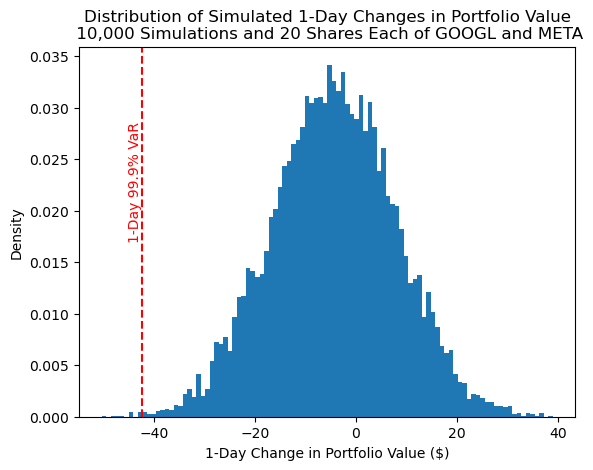

In [58]:
fig, ax = plt.subplots()
ax.hist(V_diff, bins=100, density=True)
ax.axvline(x=var[2], color='red', ls='--')
ax.text(
    x=var[2],
    y=0.8,
    s=f'1-Day {100-percentiles[2]:0.1f}% VaR',
    color='red',
    ha='right',
    va='top',
    rotation=90,
    transform=ax.get_xaxis_transform()
)
ax.set_xlabel('1-Day Change in Portfolio Value ($)')
ax.set_ylabel('Density')
ax.set_title(f'Distribution of Simulated 1-Day Changes in Portfolio Value\n {n:,.0f} Simulations and 20 Shares Each of GOOGL and META')
plt.show()